In [1]:
#!nvidia-smi

In [2]:
import sys
sys.path.append("/nix/store/z65l1jqvxa58zzwwa3bvglb6asj4y8cv-python3-3.8.5/bin/python")

# Packages we need
import os
import torch
import random
import numpy as np
import transformers
import pandas as pd
from PIL import Image
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from typing import Callable, Optional
from matplotlib import pyplot as plt
from tqdm import tqdm

## For Reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

## Tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

## Device Configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Everything works")
print(device)

Everything works
cuda


In [3]:
# File paths
data_dir = './data/flickr30k_images'
image_dir = f'{data_dir}/flickr30k_images'
csv_file = f'{data_dir}/results.csv'

In [4]:
# There's an error on line 19999 of this dataset, I had to search this up to fix it
df = pd.read_csv(csv_file, delimiter='|')
df[' comment_number'][19999] = ' 4'
df[' comment'][19999] = ' A dog runs across the grass .'
df['image_name'] = image_dir+'/'+df['image_name']
df.head(5)

# Sort the data into a data frame with 4 comment cells on each row
image_name = {
    'image_name':df[df[' comment_number'] == df[' comment_number'][0]]['image_name'].values,
}
comments = {
    'comment_0':df[df[' comment_number'] == df[' comment_number'][0]][' comment'].values,
    'comment_1':df[df[' comment_number'] == df[' comment_number'][1]][' comment'].values,
    'comment_2':df[df[' comment_number'] == df[' comment_number'][2]][' comment'].values,
    'comment_3':df[df[' comment_number'] == df[' comment_number'][3]][' comment'].values,
    'comment_4':df[df[' comment_number'] == df[' comment_number'][4]][' comment'].values,
}

image_name_df = pd.DataFrame.from_dict(image_name)
comments_df = pd.DataFrame.from_dict(comments)

df = pd.concat([image_name_df,comments_df], axis=1)
df.head(5)

,image_name,comment_0,comment_1,comment_2,comment_3,comment_4
0,./data/flickr30k_images/flickr30k_images/10000...,Two young guys with shaggy hair look at their...,"Two young , White males are outside near many...",Two men in green shirts are standing in a yard .,A man in a blue shirt standing in a garden .,Two friends enjoy time spent together .
1,./data/flickr30k_images/flickr30k_images/10002...,Several men in hard hats are operating a gian...,Workers look down from up above on a piece of...,Two men working on a machine wearing hard hats .,Four men on top of a tall structure .,Three men on a large rig .
2,./data/flickr30k_images/flickr30k_images/10002...,A child in a pink dress is climbing up a set ...,A little girl in a pink dress going into a wo...,A little girl climbing the stairs to her play...,A little girl climbing into a wooden playhouse,A girl going into a wooden building .
3,./data/flickr30k_images/flickr30k_images/10003...,Someone in a blue shirt and hat is standing o...,A man in a blue shirt is standing on a ladder...,A man on a ladder cleans the window of a tall...,man in blue shirt and jeans on ladder cleanin...,a man on a ladder cleans a window
4,./data/flickr30k_images/flickr30k_images/10003...,"Two men , one in a gray shirt , one in a blac...",Two guy cooking and joking around with the ca...,Two men in a kitchen cooking food on a stove .,Two men are at the stove preparing food .,Two men are cooking a meal .


In [5]:
## Training and Test splits 
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Split training into training and validation 
train, val = train_test_split(train, test_size=0.25, random_state=42)

## Reset Indexes 
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

## Get sizes
print(train.shape)
print(val.shape)
print(test.shape)

(19069, 6)
(6357, 6)
(6357, 6)


In [6]:
class FlickrDataset(Dataset):
    def __init__(self, data, 
                 transforms: Optional[Callable] = None) -> None:
        self.data = data
        self.transforms = T.Compose([
            T.Resize((256,256)),
            T.ToTensor(),
            T.Normalize(mean = [0.5], std = [0.5]),
        ])
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, i: int):
        image_name = self.data.image_name.values[i]
        image = Image.open(image_name).convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        comments = self.data[self.data.image_name == image_name].values.tolist()[0][1:]
        encoded_inputs = tokenizer(comments,
                            return_token_type_ids = False, 
                            return_attention_mask = False, 
                            max_length = 100, 
                            padding = "max_length",
                            return_tensors = "pt")
        
        sample = {"image":image.to(device),
                  "captions": encoded_inputs["input_ids"].flatten().to(device)}
        
        return sample

In [7]:
# Because our dataset has an odd number of files, drop_last ensures we don't get errors
batch_size = 16

train_dataset = FlickrDataset(train, transforms = True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = FlickrDataset(val, transforms = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,drop_last=True)

test_dataset = FlickrDataset(test, transforms = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


group of people standing on a snow covered ground, some are holding brooms, there is a dog with the group. adults in winter jackets and hats swing brooms at a little yellow ball while a black dog looks on. a group of people with brooms standing in the snow with a dog in the forefront. a group of people playing in the snow with brooms. a group of people and a dog sweeping snow.


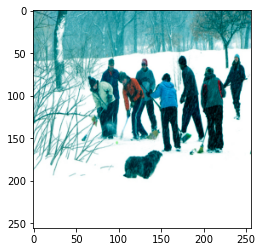

In [8]:
# Visualize a random image and its comment
plt.imshow(train_dataset[42]['image'].permute(1,2,0).cpu())
print(tokenizer.decode(train_dataset[42]['captions'].cpu(),
                       skip_special_tokens = True))

In [9]:
# The CNN - Based on ResNet
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        model = models.resnet50(pretrained=True)
        # Freeze the resnet
        for param in model.parameters():
            param.requires_grad_(False)
        
        # Replace the output with our own embedding
        modules = list(model.children())[:-1]
        self.model = nn.Sequential(*modules)
        self.embed = nn.Linear(model.fc.in_features * 4, embed_size)
        
    def forward(self, image):
        features = self.model(image)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        
        return features

In [10]:
# The RNN
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size,
                embedding_dim, vocab_size):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(num_embeddings = vocab_size,
                                     embedding_dim = embedding_dim)
        
        self.lstm = nn.LSTM(input_size = input_size,
                           hidden_size = hidden_size,
                           batch_first = True)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def init_hidden(self, features):
        # Intialize the hidden state, similar to an earlier lab
        return (torch.autograd.Variable(torch.zeros(1,batch_size, self.hidden_size).to(device)),
               torch.autograd.Variable(features.unsqueeze(0)).to(device))
    
    def forward(self, features, captions):
        state = self.init_hidden(features)
        embed = self.embedding(captions)
        lstm_out, state = self.lstm(embed, state)
        outputs = self.fc(lstm_out)
        outputs = outputs.view(-1, self.vocab_size)
        
        return outputs

In [11]:
vocab_size = 90000
steps_per_epoch = 19069 // 32

encoder = Encoder(embed_size = 512).to(device)
decoder = Decoder(input_size = 512, 
                  hidden_size = 512, 
                  embedding_dim = 512, 
                  vocab_size = vocab_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
params = list(decoder.parameters()) + list(encoder.embed.parameters())

optimizer = torch.optim.Adam(params, lr = 0.001)

In [12]:
def accuracy(output, truth):
    x = tokenizer.decode(output.cpu())
    y = tokenizer.decode(truth.cpu())
    return sentence_bleu([x], y)

In [13]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

import gc
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()
for epoch in range(10):
    #pbar = tqdm(total=len(train_loader))

    for i, sample in enumerate(train_loader):
        if i > steps_per_epoch:
            break
        
        # Get the info
        image, captions = sample['image'], sample['captions']
        
        # Zero grad
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Forward
        features = encoder(image)
        outputs = decoder(features, captions)
        print(tokenizer.decode(captions))
        
        # Loss
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        train_losses.append(loss.item())
        train_accs.append(accuracy(outputs, captions))
        
        loss.backward()
        optimizer.step()
    

ValueError: only one element tensors can be converted to Python scalars